# Assignment2 - Supervised Learning flow

### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Lihi Nahum 9966
# student 2: Asaf Yosef 4322
# student 3: Nofit Anchel 1770
# student 4:
# (optional) student 5:
# (optional) student 6:

## Part 2 - Experiments
You could add as many code cells as needed

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score,classification_report
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


loading the csv files into data frames and show 5 first rows of each data frame.

In [3]:
train_df = pd.read_csv('titanic_train.csv')
train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [4]:
test_df = pd.read_csv('titanic_test.csv')
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


 # Preprocessing
### Data Cleansing
### Handle duplicated rows

In [5]:
train_num_rows = train_df.shape[0]
print(f"Number of rows in train data frame: {train_num_rows}")

train_df.drop_duplicates(keep='first',inplace=True)
train_df = train_df.reset_index(drop=True)
train_num_rows = train_df.shape[0]

print(f"Number of rows in train data frame after removing duplicated rows is: {train_num_rows}\n")

Number of rows in train data frame: 712
Number of rows in train data frame after removing duplicated rows is: 632



### Handle none values

In [6]:
train_columns_with_none = train_df.columns[train_df.isnull().any()]
for column in train_columns_with_none:
    print(column)
test_columns_with_none = test_df.columns[test_df.isnull().any()]
for column in test_columns_with_none:
    print(column)

As we see, There are not none values in our data frames.

 # EDA & Feature Engineering
### Exploratory Data Analysis

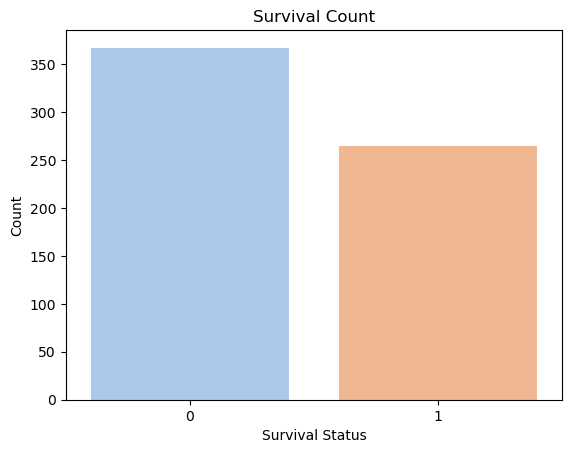

In [7]:
sns.countplot(x='Survived', data=train_df, palette='pastel')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

The count plot clearly illustrates that the number of passengers who did not survive exceeds the count of those who survived.

### Viewing all pairs correleations
The next code will show the correlation between every 2 features in our dataset in a heat matrix.

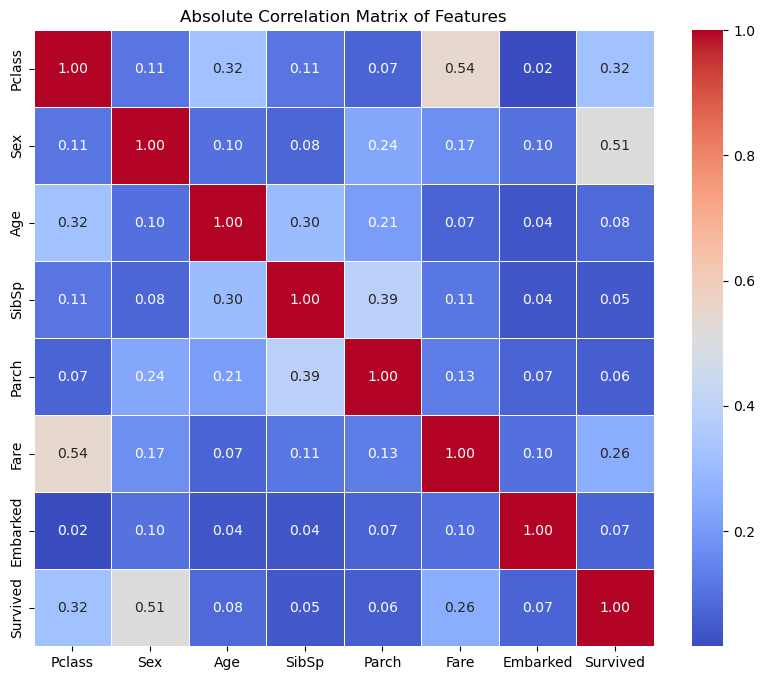

In [8]:
correlation_matrix = train_df.corr()

absolute_correlation_matrix = correlation_matrix.abs()

plt.figure(figsize=(10, 8))
sns.heatmap(absolute_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Absolute Correlation Matrix of Features')
plt.show()

### High Correlation Pairs in Training Data

This section identifies and lists pairs of features in the training dataset that have a high correlation coefficient (greater than 0.3) after removing duplicate pairs and self-correlations.


In [9]:
df_train_corr = train_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.3
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Fare,Pclass,0.542995
10,Survived,Sex,0.514598
12,SibSp,Parch,0.391679
14,Pclass,Survived,0.323125
16,Age,Pclass,0.322891
18,Age,SibSp,0.300990


### High Correlation Pairs in Test Data


In [10]:
df_test_corr = test_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.3
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,Fare,0.574241
10,Survived,Sex,0.509608
12,Parch,Fare,0.471795
14,SibSp,Parch,0.417181
16,Pclass,Survived,0.395163
18,Age,Pclass,0.388599


Upon review of both the test and training datasets, a notable correlation was observed between the 'Pclass' (passenger class) and 'Fare' variables. This correlation is intuitive, as passengers in first class typically have higher fares.

Similarly, the 'Survived' variable, indicating passenger survival, displays a significant correlation with the 'Sex' attribute.

### exploration of the correlation between Survived and sex

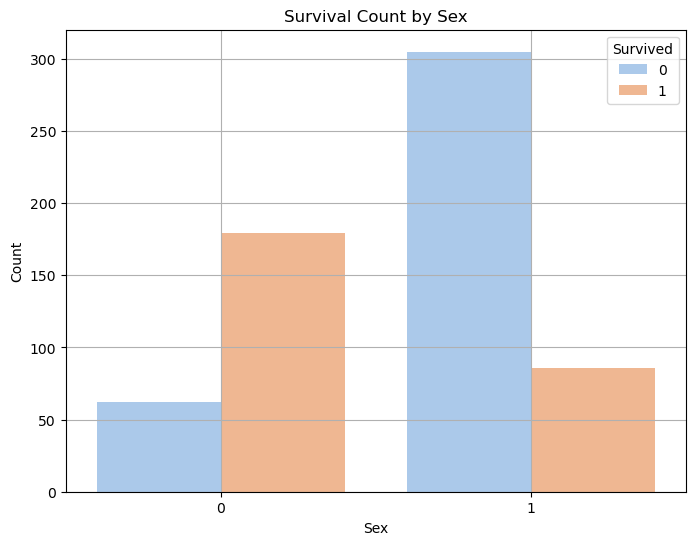

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Survived', data=train_df,palette='pastel')
plt.title('Survival Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(True)
plt.show()


As evident from the plot above, the survival rate among males significantly surpasses that among females.

In [12]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean()


,Survived
Sex,
0,0.742739
1,0.219949


### Let's enhance our dataset by creating a new column that combines existing information in a meaningful way. 

In [13]:
def process_family_size(df):
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = df['Family_Size'].apply(lambda x: 1 if x == 1 else 0)
    df = df.drop(['SibSp', 'Parch', 'Family_Size'], axis=1)
    return df

In [14]:
train_df = process_family_size(train_df)
test_df = process_family_size(test_df)


In [15]:
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.500000
1,0.355114


As we see, the likelihood of survival appears to increase when passengers are not traveling alone.

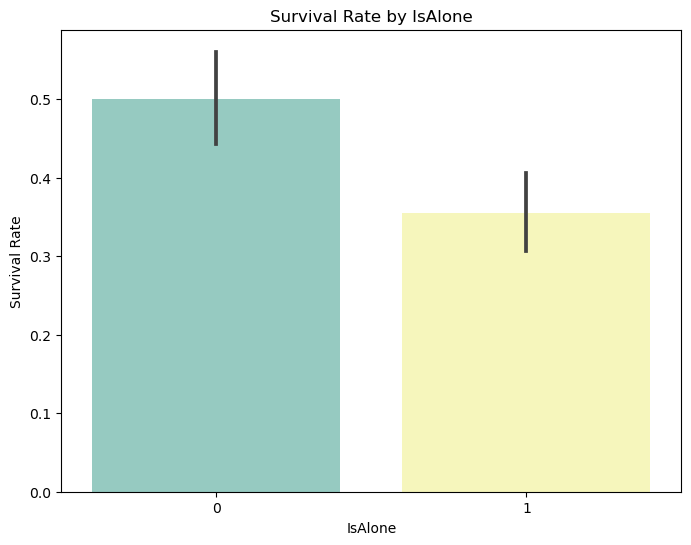

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x="IsAlone", y="Survived", data=train_df, palette="Set3")
plt.title("Survival Rate by IsAlone")
plt.xlabel("IsAlone")
plt.ylabel("Survival Rate")
plt.show()

## Data Handling
In our dataset, we have a total of 6 feature columns. Among these:

2 columns represent continuous variables: 'Age' and 'Fare'.
2 columns are binary: 'IsAlone' and 'Sex'.
1 column is categorical ordinal: 'Pclass'.
1 column is categorical without order: 'Embarked'.
We need to handle missing values and perform preprocessing on the continuous variables 'Age' and 'Fare', as well as the categorical variable 'Embarked', which lacks an inherent order. The binary columns and 'Pclass' do not require further handling.

### We are creating a copy of our data frames for further analysis (for separation from the best permutation search )

In [17]:
train_df_copy = train_df.copy()
test_df_copy= test_df.copy()

### Performing one-hot encoding for Embarked column

In [18]:
train_df_copy = pd.get_dummies(train_df, columns=['Embarked'], prefix='Embarked')
test_df_copy = pd.get_dummies(test_df, columns=['Embarked'], prefix='Embarked')


### Performing standardization scaling on Age and Fare columns

In [19]:
numeric_features = ['Age', 'Fare']
scaler = StandardScaler()
train_df_copy[numeric_features] = scaler.fit_transform(train_df_copy[numeric_features])
test_df_copy[numeric_features] = scaler.transform(test_df_copy[numeric_features])


### Splitting the data to train and test set for using machine learning models

In [20]:
x_train_copy= train_df_copy.drop(columns=['Survived'])
y_train_copy = train_df_copy['Survived']

x_test_copy = test_df_copy.drop(columns=['Survived'])
y_test_copy= test_df_copy['Survived']

## First model : KNN
We are experimenting with a K-Nearest Neighbors  model, configured with 100 neighbors and utilizing Manhattan distance.

In [21]:
knn = KNeighborsClassifier(n_neighbors=100,p=1)  

knn.fit(x_train_copy, y_train_copy)

y_pred = knn.predict(x_test_copy)

f1 = f1_score(y_test_copy, y_pred)

print("F1 Score:", f1)

F1 Score: 0.7058823529411764


We are not very satisfied from the score knn achieved. let's try another model.

## Second model : Random Forest
We ensure consistent results by setting the random seed to 100 using the parameter random_state. Additionally, we construct a forest of 200 trees, specifying n_estimators, and limit the maximum depth of each tree to 3 with the parameter max_depth.

In [22]:
rf_classifier = RandomForestClassifier(max_depth=3,n_estimators=200,random_state=100)

rf_classifier.fit(x_train_copy, y_train_copy)

y_pred = rf_classifier.predict(x_test_copy)

f1 = f1_score(y_test_copy, y_pred)

print("F1 Score:", f1)

F1 Score: 0.7547169811320755


Random Forest achieved higher f1 score than knn.

### Feature Importance
Let's try raising the score by training our model exclusively on the most influential features. To do this, we'll identify these features first:

In [23]:
feature_names = x_train_copy.columns

feature_importances = rf_classifier.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

feature_importance_df = pd.DataFrame({'Feature': feature_names[sorted_indices],'Importance': feature_importances[sorted_indices]})

feature_importance_df

,Feature,Importance
0,Sex,0.493729
1,Pclass,0.189278
2,Fare,0.162505
3,Age,0.096735
4,Embarked_1,0.023881
5,IsAlone,0.018194
6,Embarked_0,0.009964
7,Embarked_2,0.005057
8,Embarked_3,0.000658


### This diagram illustrates the importance of each feature in the Random Forest classifier, with taller bars indicating features that have a greater impact on the model's predictions.

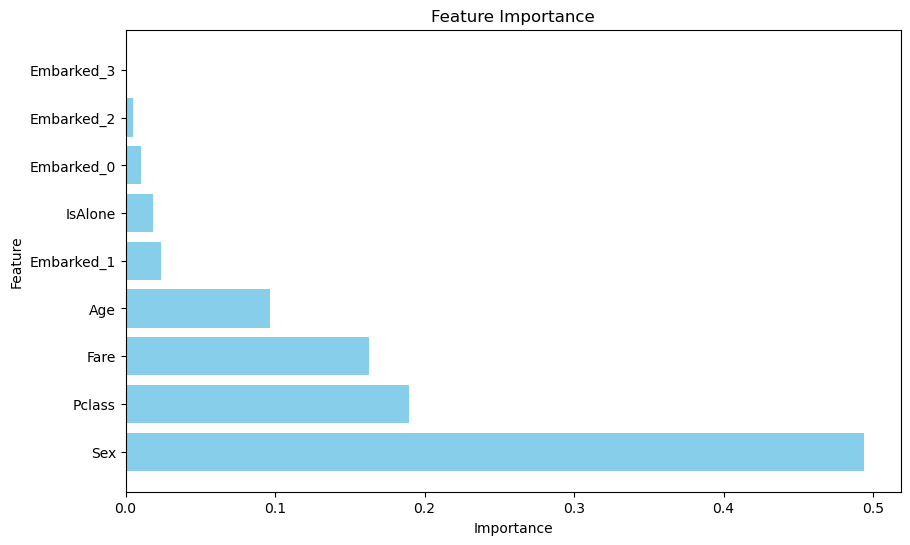

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')

plt.show()

### Training our model solely on the top 4 most significant features:
sex, Pclass, Fare and Age.

In [25]:
top_features = feature_names[sorted_indices[:4]]

x_train_top = x_train_copy[top_features]
x_test_top = x_test_copy[top_features]

rf_classifier_top = RandomForestClassifier(max_features='sqrt', max_depth=3, n_estimators=200, random_state=100)
rf_classifier_top.fit(x_train_top, y_train_copy)

y_pred_top = rf_classifier_top.predict(x_test_top)
f1_top = f1_score(y_test_copy, y_pred_top)
print("F1 Score on Test Set (using only top 4 features):", f1_top)


F1 Score on Test Set (using only top 4 features): 0.7321428571428572


The decrease in score suggests that we might have lost crucial information necessary for accurate predictions by training the model only on the top 4 features.

## Third model: Gradient Boosting
Gradient Boosting captures complex relationships between features and the target variable, which is crucial for our prediction. Additionally, Gradient Boosting is robust to outliers and noisy data, making it suitable for real-world datasets like ours.
We ensure consistent results also in this model by setting the random seed to 100 using the parameter random_state. In addition, we construct a forest of 300 trees, specifying n_estimators, and limit the maximum depth of each tree to 6 with the parameter max_depth.

In [26]:
gb_classifier = GradientBoostingClassifier(max_depth=6,n_estimators=300,random_state=100)

gb_classifier.fit(x_train_copy, y_train_copy)
y_pred = gb_classifier.predict(x_test_copy)

f1 = f1_score(y_test_copy, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8


### We achieved 80% !

## Finding the best model & parameters permutation

### Splitting to train and test

In [27]:
X_train= train_df.drop(columns=['Survived'])
y_train = train_df['Survived']

X_test = test_df.drop(columns=['Survived'])
y_test= test_df['Survived']

### Defining to each feature the proper scaling

In [28]:
numeric_features = ['Age', 'Fare']
categorical_features = ['Embarked']
unchanged_features = ['Sex', 'IsAlone', 'Pclass']

In [29]:
# Assuming you have defined X_train, y_train, numeric_features, categorical_features, unchanged_features

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'None': 'passthrough'  # Adding 'None' option for no scaling
}

results = []

# Running on all Scalers & Models & Params with grid search
for scaler_name, scaler in scalers.items():
    if scaler_name == 'None':
        numeric_transformer = 'passthrough'  # No scaling applied
    else:
        numeric_transformer = Pipeline(steps=[
            ('scaler', scaler)
        ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('unchanged', 'passthrough', unchanged_features)
    ])

    models = {
        'RandomForestClassifier': {
            'model': RandomForestClassifier(random_state=100),
            'params': {
                'classifier__n_estimators': np.arange(50, 301, 50),
                'classifier__max_depth': [10, 20, 30, None],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]
            }
        },
        'GradientBoostingClassifier': {
            'model': GradientBoostingClassifier(random_state=100),
            'params': {
                'classifier__n_estimators': np.arange(100, 401, 100),
                'classifier__learning_rate': [0.01, 0.05, 0.1],
                'classifier__max_depth': [3, 4, 5, 6],
            }
        },
        'KNeighborsClassifier': {
            'model': KNeighborsClassifier(),
            'params': {
                'classifier__n_neighbors': np.arange(1, 31),
                'classifier__weights': ['uniform', 'distance'],
                'classifier__metric': ['euclidean', 'manhattan']
            }
        }
    }

    for model_name, mp in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', mp['model'])
        ])

        search = GridSearchCV(pipe, mp['params'], cv=5, scoring='f1', return_train_score=True)
        search.fit(X_train, y_train)

        for i, params in enumerate(search.cv_results_['params']):
            results.append({
                'Model': model_name,
                'Scaler': scaler_name if scaler_name != 'None' else 'None',
                'Params': params,
                'Mean Test Score': search.cv_results_['mean_test_score'][i],
                'Std Test Score': search.cv_results_['std_test_score'][i]
            })

# Creating the DataFrame with all the results
all_results_df = pd.DataFrame(results)
all_results_df


,Model,Scaler,Params,Mean Test Score,Std Test Score
0,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.695262,0.051826
1,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.701384,0.062427
2,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.701646,0.055617
3,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.712749,0.050035
4,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.708115,0.050372
...,...,...,...,...,...
1147,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.582850,0.036111
1148,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.567419,0.053362
1149,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.586518,0.033692
1150,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.559620,0.062480


### Using transformation&scaling pre-pipeline

#### Finding the best permutation for each model

In [30]:
best_results = all_results_df.loc[all_results_df.groupby(['Model', 'Scaler'])['Mean Test Score'].idxmax()]
print("\nBest results for each model:")
best_results


Best results for each model:


,Model,Scaler,Params,Mean Test Score,Std Test Score
610,GradientBoostingClassifier,MinMaxScaler,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
994,GradientBoostingClassifier,None,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
226,GradientBoostingClassifier,StandardScaler,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
719,KNeighborsClassifier,MinMaxScaler,"{'classifier__metric': 'manhattan', 'classifie...",0.695902,0.057164
1096,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.621971,0.029679
332,KNeighborsClassifier,StandardScaler,"{'classifier__metric': 'manhattan', 'classifie...",0.697760,0.038118
486,RandomForestClassifier,MinMaxScaler,"{'classifier__max_depth': 20, 'classifier__min...",0.750050,0.049005
854,RandomForestClassifier,None,"{'classifier__max_depth': 20, 'classifier__min...",0.754325,0.048592
86,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 20, 'classifier__min...",0.752837,0.047148


#### Finding the model with the best score

In [31]:
best_model = best_results.loc[best_results['Mean Test Score'].idxmax()]
print("\nBest model overall:")
best_model_df=pd.DataFrame([best_model])
best_model_df


Best model overall:


,Model,Scaler,Params,Mean Test Score,Std Test Score
854,RandomForestClassifier,None,"{'classifier__max_depth': 20, 'classifier__min...",0.754325,0.048592


In [32]:
print("\nBest model parameters:")
best_params = best_model_df['Params'].iloc[0]
print(best_params)


Best model parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}


## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part and then running it on the whole train data (The model & hyper parameters & scalers are chosen dynamically)

In [33]:
#Getting the best model and scaler
best_model_name = best_model_df['Model'].iloc[0]
best_scaler_name = best_model_df['Scaler'].iloc[0]

if best_scaler_name == 'StandardScaler':
    best_scaler = StandardScaler()
elif best_scaler_name == 'MinMaxScaler':
    best_scaler = MinMaxScaler()
else:
    best_scaler=None
    

In [34]:
#removing the 'classifier__' prefix
best_params = {k.split('__')[1]: v for k, v in best_params.items()}

In [35]:
#Giving to the best model his parameters
if best_model_name == 'RandomForestClassifier':
    best_model_instance = RandomForestClassifier(random_state=100, **best_params)
elif best_model_name == 'GradientBoostingClassifier':
    best_model_instance = GradientBoostingClassifier(random_state=100, **best_params)
else:
    best_model_instance = KNeighborsClassifier(**best_params)

In [36]:
# Creating the pipeline with the final params 
final_pipe = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('scaler', best_scaler)]), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('unchanged', 'passthrough', unchanged_features)
        ]
    )),
    ('classifier', best_model_instance)
])

#Training on the the last time
final_pipe.fit(X_train, y_train)

print("\nModel trained with best combination on entire training set.")


Model trained with best combination on entire training set.


## Part 4 - Apply on test and show model performance estimation

#### The final pipeline we created will help to predict the wanted values using the wanted feature engineering process

In [37]:
#Predicting on the test set
y_pred = final_pipe.predict(X_test)

#### Printing the first 10 predicted classifications VS the real classifications

In [38]:
comparison_df = pd.DataFrame({'Actual': y_test[:10],'Predicted': y_pred[:10]})
comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted']

print("Comparison of the first 10 values:")
comparison_df

Comparison of the first 10 values:


,Actual,Predicted,Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,1,0,False
5,1,0,False
6,0,0,True
7,0,0,True
8,1,1,True
9,0,0,True


#### Showing the model's performance report

In [39]:
#Evaluating the model performance on the test set
print("\nClassification report on the test set:")
print(classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived']))
classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived'])


Classification report on the test set:
              precision    recall  f1-score   support

Not Survived       0.88      0.91      0.89       118
    Survived       0.81      0.75      0.78        61

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



'              precision    recall  f1-score   support\n\nNot Survived       0.88      0.91      0.89       118\n    Survived       0.81      0.75      0.78        61\n\n    accuracy                           0.85       179\n   macro avg       0.84      0.83      0.84       179\nweighted avg       0.85      0.85      0.85       179\n'

In [40]:
#Evaluating the model's general F1 score
f1 = f1_score(y_test, y_pred)
print(f"\nOverall F1 score: {f1:.2f}")


Overall F1 score: 0.78
